In [40]:
batch_size = 100
learning_rate = 0.001
training_epochs = 15

In [41]:
import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torch.nn.init

In [42]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'     # 처리속도 향상을 위해 그래픽카드 사용하는 구문. 그래픽 카드가 없으면 'cpu' 사용 / 많이 쓰는 구문

In [43]:
# dataset
mnist_train = dsets.MNIST(root='MNIST_data/', train=True,
                          transform = transforms.ToTensor(), download=True)    # 훈련집합(tensor, 4차원 배열로 변환)
mnist_test = dsets.MNIST(root='MNIST_data/', train=False,
                          transform = transforms.ToTensor(), download=True)    # 테스트집합
                          

3


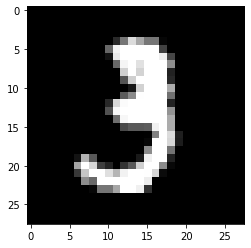

In [44]:
import matplotlib.pyplot as plt
plt.imshow(mnist_train[10][0].numpy().reshape(28,28), cmap='gray')     # tensor를 2차원 행렬로 변환 / 첫번째 []는 데이터 인덱스, 두번째 []는 레이블 유무(0 = 시각화 / 1 = 데이터 값(레이블))
print(mnist_train[10][1])       # 두번째 []가 1이므로 데이터 값 출력
plt.show()

In [45]:
 # 학습용 데이터 
data_loader = torch.utils.data.DataLoader(dataset=mnist_train,                  # mnist_train을 학습데이터로 사용
                                          batch_size = batch_size,
                                          shuffle=True,
                                          drop_last=True)

In [46]:
# fully connected 클래스 생성(MLP)

class FC(torch.nn.Module):                                     # 해당 모듈에서 불러 사용 가능(해당 모듈 객체를 상속)
    def __init__(self):                                        # 추가적으로 사용할 속성만 선언
      super(FC,self).__init__()                                # 여러가지의 속성이 있는데 super 함수를 사용하면 앞에서 만들어 놓은 것들을 그대로 상속 받아 사용 가능
      self.layer1 = torch.nn.Sequential(                       # sequential : 차례차례 순차적으로 처리
          torch.nn.Linear(28*28, 100, bias=True),              # hidden node 100개, bias node = True
          torch.nn.ReLU()                                      # ReLU 활성함수(분류, classification) 지정
      )
      self.layer2 = torch.nn.Linear(100, 10)                   # hidden node 100개 / output(class 0-9) 10개
      torch.nn.init.xavier_uniform_(self.layer2.weight)        # 2번째 레이어(output)의 weight 초기화() / FC에서 많이 사용 / __init__(self):함수 안에서 구현이 되는데 처음에 클래스를 만들 때 동작하고 이후에는 동작하지 않음 ==> 처음에만 초기화

    def forward(self,x):                                       # forward method 정의(순방향 계산)
      x2 = x.view(x.size(0), -1)                               # input으로 들어온 28*28 샘플을 각각 열행렬로 변환 ==> 784*1 행렬
      out = self.layer1(x2)                                    # layer1의 param으로 x2
      out = self.layer2(out)                                   # layer2의 param으로 layer1의 값(100개의 히든노드를 거쳐 나온 활성값)을 out에 대입
      return out                                               # out return

In [69]:
# CNN class 생성

class CNN(torch.nn.Module):                                     
    def __init__(self):                                      
      super(CNN,self).__init__()                                                  # super 함수를 사용해 앞에서 만들어 놓은 것들을 그대로 상속 받아 사용 가능
      self.layer1 = torch.nn.Sequential(                                          # 히든 1층(컨볼루션 1층, 맥스풀링 1층)
          torch.nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),             # 1장(28*28)을 32장으로
          torch.nn.ReLU(),                                                        # ReLU 활성함수(분류, classification) 
          torch.nn.MaxPool2d(kernel_size=2, stride=2)                             # 맥스풀링층 추가
      )
      self.layer2 = torch.nn.Sequential(                                          # 히든 2층(컨볼루션 1층, 맥스풀링 1층)
          torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),            # 32장을 64장으로
          torch.nn.ReLU(),                                    
          torch.nn.MaxPool2d(kernel_size=2, stride=2)
      )
      self.fc = torch.nn.Linear(7*7*64, 10, bias=True)                            # fc층 / output(class 0-9) 10개
      torch.nn.init.xavier_uniform_(self.fc.weight)                               # weight 초기화() / FC에서는 이 방법으로 초기화를 많이 사용

    def forward(self,x):                                       
      out = self.layer1(x)                                                        # x가 바로 layer1의 param으로 들어감(컨볼루션 층이기 때문에 변환x)
      out = self.layer2(out)                                                      # layer2의 param으로 layer1의 값(100개의 히든노드를 거쳐 나온 활성값)을 out에 대입
      out = out.view(out.size(0), -1)                                             # fc 층에 들어가기 전에 열행렬로 변환
      out = self.fc(out)                                                          # fc 층에 값 넣기
      return out                                                                  # out return / 총 5개층

In [70]:
# instance 생성
# model = FC().to(device)          # 연산처리를 그래픽에서 실행할 수 있도록 설정 / FC
model = CNN().to(device)          # CNN

In [71]:
# 목적함수 설정(파라미터, 가중치 최적화를 위한 함수 / optimizer = stochastic gradient descent, batch gradient descent 등)
criterion = torch.nn.CrossEntropyLoss().to(device)         # Cross Entropy
# criterion = torch.nn.MSELoss.to(device)                  # MSE
# criterion = torch.nn.NLLLoss().to(device)                # 로그우도


# 가중치 최적화
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)       # stochastic gradient descent 아니고 더 좋은 거

In [72]:
# 본격적인 학습 시작(machine learning)

# print(len(data_loader))  ==> 600개 / training set의 데이터 전체 개수는 60,000개. 이때, batch_size가 100이기 때문에 100개씩 나누면 600개의 set. 
total_batch = len(data_loader)             # 한 epoch을 돌 때 총 batch 개수

for epoch in range(training_epochs):
  avg_cost = 0                             # 손실 비용, loss function, 목적함수 값이 감소되는 것을 확인하기 위함

  for X,Y in data_loader:
    X = X.to(device)
    Y = Y.to(device)
    optimizer.zero_grad()
    hypothesis = model(X)                  # model instance에 훈련 feature X를 넣어 out(출력값)을 hypothesis에 대입
    cost = criterion(hypothesis, Y)        # hypothesis와 훈련집합의 Y(label, 실제 정답)을 목적함수에 넣어 
    cost.backward()                        
    optimizer.step()                       # 모형 학습(cost.backward()와 optimizer.step() 두 과정을 모형학습이라고 할 수 있음)

    avg_cost += cost/total_batch           # 한 단위인 batch_size(100)별로 계산된 cost를 다 합한 후(600개), total_batch로 나눠 avg_cost 계산
    # print("cost: ", cost)
    # print("avg_cost: ", len(avg_cost))

  print("[Epoch: {:>4}, cost: {:>.9}]".format(epoch+1, avg_cost))

[Epoch:    1, cost: 0.226127863]
[Epoch:    2, cost: 0.0612153225]
[Epoch:    3, cost: 0.0464232191]
[Epoch:    4, cost: 0.0365589708]
[Epoch:    5, cost: 0.0309077594]
[Epoch:    6, cost: 0.0254950449]
[Epoch:    7, cost: 0.0215110164]
[Epoch:    8, cost: 0.0184704587]
[Epoch:    9, cost: 0.0147461956]
[Epoch:   10, cost: 0.0129029267]
[Epoch:   11, cost: 0.0118002249]
[Epoch:   12, cost: 0.00966401398]
[Epoch:   13, cost: 0.00789414253]
[Epoch:   14, cost: 0.00736873457]
[Epoch:   15, cost: 0.00619690772]


In [73]:
with torch.no_grad():                                                                 # gradient 없이 계산하겠다는(with를 써서), 테스트 데이터 셋으로 정확도 파악
    X_test = mnist_test.test_data.view(len(mnist_test),1,28,28).float().to(device)    # 10,000 * 1 * 28 * 28의 tensor로 변환
    Y_test = mnist_test.test_labels.to(device)                                        # 정수(값)

    # output
    prediction = model(X_test)                                                        # 훈련집합 X,Y로 model의 가중치를 업데이트 했기 때문에 X_test를 넣어주기만 하면 최신 가중치의 out 값 출력 
    print(prediction.size())                                                          # torch.Size([10000, 10]) ==> 10,000개의 샘플들의 0-9까지의 클래스 결과(확률)이 나옴, 가장 큰 값(확률)로 분류(argmax)
    print(torch.argmax(prediction,1))                                                 # tensor([7, 2, 1,  ..., 4, 5, 6], device='cuda:0') ==> 10,000개의 분류된 값 출력 

    correct_prediction = torch.argmax(prediction, 1) == Y_test                        # 답지와 비교
    print(correct_prediction)                                                         # type = class 'torch.Tensor' / not list

    accuracy = correct_prediction.float().mean()                                      # 1, 0으로 변환해서 평균 계산
    print("Accuracy: ", accuracy.item())                                              # 정확도 (FC: 97.78999 / CNN: 98.4499999)
    # print(type(accuracy))

torch.Size([10000, 10])
tensor([7, 2, 1,  ..., 4, 5, 6], device='cuda:0')
tensor([True, True, True,  ..., True, True, True], device='cuda:0')
Accuracy:  0.984499990940094


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:63: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:53: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")
